In [15]:
import numpy as np
import matplotlib.pyplot as plt
import random

from progress.bar import Bar
import statsmodels
from statsmodels.graphics.tsaplots import plot_acf

import collections
import numpy.fft as fft
import collections
from scipy.signal import find_peaks, spectrogram, stft
from scipy.fft import fftshift
from matplotlib.colors import LogNorm

# Spectrogram

In [16]:
def simulation_Q(Q):
    
    nCell = 100
    ##constantes
    n = 2
    alpha = 111
    kappa = 20
    k_s0 = 1
    k_s1 = 0.01
    t = 3000 # pour réduire le temps de calcul
    eta = 2.0

    D = 0.04

    beta = []
    for i in range(nCell):
        beta.append(random.gauss(1,0.05))
    tau = 0.04 ##a voir

    ##initialisation des matrices
    a = np.zeros((nCell, t))
    bQ1 = np.zeros((nCell, t))
    c = np.zeros((nCell, t))

    A = np.zeros((nCell, t))
    B = np.zeros((nCell, t))
    C = np.zeros((nCell, t))

    S = np.zeros((nCell, t))
    Se = np.zeros((nCell, t))

    a[:,0] = 0
    bQ1[:,0] = 50
    c[:,0] = 0

    A[:,0] = 0
    B[:,0] = 0
    C[:,0] = 0

    S[:,0] = 0
    Se[:,0] = 0

    time = np.arange(0,t)

    for j in range(0, t-1):
        for i in range(0, nCell):
            xi = random.gauss(0, D)
            betabis = beta[i] + (xi*tau)

            Se[i, j] = Q * np.mean(S[:, j])

            abis = a[i, j] + tau / 2 * (-a[i, j] + (alpha / (1 + C[i, j] ** n)))
            bbis = bQ1[i, j] + tau / 2 * (-bQ1[i, j] + (alpha / (1 + A[i, j] ** n)))
            cbis = c[i, j] + tau / 2 * (-c[i, j] + (alpha / (1 + B[i, j] ** n)) + (kappa * S[i, j] / 1 + S[i, j]))

            Abis = A[i, j] + tau / 2 * (betabis * (a[i, j] - A[i, j]))
            Bbis = B[i, j] + tau / 2 * (betabis * (bQ1[i, j] - B[i, j]))
            Cbis = C[i, j] + tau / 2 * (betabis * (c[i, j] - C[i, j]))

            Sbis = S[i, j] + tau / 2 * ((-k_s0 * S[i, j]) + (k_s1 * A[i, j]) - (eta * (S[i, j] - Se[i, j])))

            a[i, j + 1] = a[i, j] + tau * (-abis + (alpha / (1 + Cbis ** n)))
            bQ1[i, j + 1] = bQ1[i, j] + tau * (-bbis + (alpha / (1 + Abis ** n)))
            c[i, j + 1] = c[i, j] + tau * (-cbis + (alpha / (1 + Bbis ** n)) + (kappa * Sbis / 1 + Sbis))

            A[i, j + 1] = A[i, j] + tau * (betabis * (abis - Abis))
            B[i, j + 1] = B[i, j] + tau * (betabis * (bbis - Bbis))
            C[i, j + 1] = C[i, j] + tau * (betabis * (cbis - Cbis))

            S[i, j + 1] = S[i, j] + tau * ((-k_s0 * Sbis) + (k_s1 * Abis) - (eta * (Sbis - Se[i, j])))
            
    btotQ1 = []
    for i in range(0, t):
        binter = 0
        for j in range(nCell):
            binter += bQ1[j,i]
        btotQ1.append(binter/nCell)

    #Centralisation de btot et b1
    btotQ1norm = (btotQ1 - (max(btotQ1)/2))/(max(btotQ1)/2)
    b1Q1norm = (bQ1[1, :] - (max(bQ1[1, :])/2))/(max(bQ1[1, :])/2)

    #Autocorrelation des valeurs : calcul la somme des multiplications des valeurs aux temps avec un décallage (b(t) * b(t+i))
    testAutocorrelQ1 = np.correlate(b1Q1norm, b1Q1norm, mode="full")
    testAutocorrelQ1 = testAutocorrelQ1[len(testAutocorrelQ1)//2:]

    #soustraction de la moyenne des valeurs à toutes les valeurs :
    averageautocorr = sum(testAutocorrelQ1)/len(testAutocorrelQ1)
    testAutocorrelQ1 = testAutocorrelQ1 - averageautocorr
    
    fourierQ1 = np.fft.fft(testAutocorrelQ1)
    freqfour1=np.fft.fftfreq(len(testAutocorrelQ1),d=tau)
        
    return fourierQ1
    #return freqfour1

In [17]:
simulation_Q(0)

array([-7.88588750e-10     +0.j        ,  4.42261776e+03-277535.83875303j,
        4.35434428e+03-128007.96991853j, ...,
        4.28277934e+03 +71461.70523916j,  4.35434428e+03+128007.96991853j,
        4.42261776e+03+277535.83875303j])

In [18]:
simulation_Q(1)

array([-1.60832769e-09     +0.j        ,  3.30278507e+03-249142.00394769j,
        3.27741366e+03-117419.75765515j, ...,
        3.18495449e+03 +68869.69202318j,  3.27741366e+03+117419.75765515j,
        3.30278507e+03+249142.00394769j])

In [13]:
list_four0 = []

for i in range(1,30):
    list_four0.append(simulation_Q(0))
    #plt.specgram(simulation_Q(0))

#print(list_four)

/home/kevin/.local/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Only one segment is calculated since parameter NFFT (=256) >= signal length (=29).
  """Entry point for launching an IPython kernel.


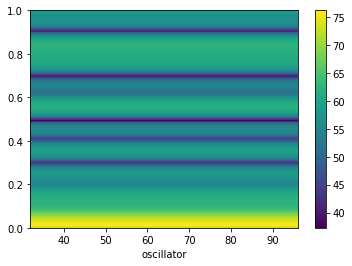

In [20]:
plt.specgram(list_four0, sides='onesided')
plt.xlabel('oscillator')
plt.colorbar()
#plt.yscale('log')

In [21]:
list_four1 = []

for i in range(1,30):
    list_four1.append(simulation_Q(0))
    #plt.specgram(simulation_Q(0))

/home/kevin/.local/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Only one segment is calculated since parameter NFFT (=256) >= signal length (=29).
  """Entry point for launching an IPython kernel.


Text(0.5, 0, 'oscillator')

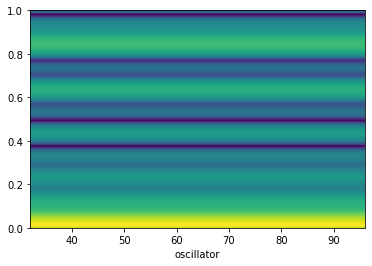

In [24]:
plt.specgram(list_four1, sides='onesided')
plt.xlabel('oscillator')
#plt.yscale('log')